In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timewarp_lib.load_model as lm
import timewarp_lib.train_utils as tu
import torch
import pandas as pd
import json
import numpy as np
import matplotlib

/home/travers/miniconda3/envs/timewarpvae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmap = plt.get_cmap("viridis")

In [3]:

####clean_model_dirs = ["../results/overnight/20230921-093159.705744/savedmodel"] # TenDTWModel



In [4]:
import matplotlib
font = {        'size'   : 22}

matplotlib.rc('font', **font)

In [5]:
datatype = "train"
dtype=torch.float
device="cpu"
batch_size=100
training_data_timing_noise=0

dataName = "../data/trainTest2DLetterARescaled.npz"
# the datafile has information on how the data was cleaned
# the learned/applied model is on clean data
# so we need to convert back to trajectory data
loaded_data_dict = np.load(dataName)

ydata = torch.tensor(loaded_data_dict[datatype],dtype=dtype).to(device)
np_ydata = ydata.detach().cpu().numpy()
num_trajs, numts, traj_channels = ydata.shape
tdata = torch.tensor(np.linspace(0,1,numts),dtype=dtype).to(device).expand(num_trajs,numts).unsqueeze(2)


In [6]:
ixs=(10,15)

In [7]:
pose_mean = loaded_data_dict["pose_mean"]
pose_scaling = loaded_data_dict["pose_scaling"]
saved_model_dir = "../results/rescaled/20231011-003229.166126/savedmodel"#,"timewarp",[135,138,141])
modelApplier = lm.LoadedModel(saved_model_dir)
modeldatafileobj = np.load(f"{saved_model_dir}/saved_model_info.npz",allow_pickle=True)
modeldata = {key : (modeldatafileobj[key] if key != "initialization_function" else True) for key in modeldatafileobj.keys()}
num_timesteps = 10001
num_channels = 2
latent_dim = (int)(modeldata["latent_dim"])

hi=modelApplier.model

seed_ts_np = np.array([np.linspace(0,1,num_timesteps).reshape(-1,1)])

def generate_trajectory_from_latents(pos_lat, time_lat):
    
    seed_ts = torch.tensor(np.array(seed_ts_np),dtype=torch.float)
    scaled_ts = (hi.scalar_timewarper.monotonic_applier.batch_apply_monotonic_transformation(time_lat,seed_ts) * (hi.scalar_timewarper.scaltw_max_canonical_time-hi.scalar_timewarper.scaltw_min_canonical_time)
                           + hi.scalar_timewarper.scaltw_min_canonical_time)
    realistic_trajs = hi.decoder.decode(pos_lat, scaled_ts).detach().numpy()
    return realistic_trajs

In [8]:
spatial_embeds,_ = hi.encoder.encode(ydata[ixs,],tdata[ixs,])

time_embeds = hi.scalar_timewarper.get_parameters_from_poses(ydata[ixs,])

seed_ts_np = np.array([np.linspace(0,1,num_timesteps).reshape(-1,1)])
print(spatial_embeds.shape, time_embeds.shape)
all_traj = []
for i in range(2):
    j=i
    spat_emb = spatial_embeds[i:i+1,]
    spat_name=f"{i}"
    time_emb = time_embeds[j:j+1,]
    time_name=f"{j}"
            
    traj = generate_trajectory_from_latents(spat_emb,time_emb)
    all_traj.append(traj)
    

before transpose torch.Size([2, 200, 2])
after transpose torch.Size([2, 2, 200])
did convolution  torch.Size([2, 16, 198])
did convolution  torch.Size([2, 32, 98])
did convolution  torch.Size([2, 64, 48])
did convolution  torch.Size([2, 32, 23])
flattened torch.Size([2, 736])
final torch.Size([2, 16])
before transpose torch.Size([2, 200, 2])
after transpose torch.Size([2, 2, 200])
did convolution  torch.Size([2, 16, 198])
did convolution  torch.Size([2, 32, 98])
did convolution  torch.Size([2, 32, 96])
did convolution  torch.Size([2, 64, 47])
did convolution  torch.Size([2, 64, 45])
did convolution  torch.Size([2, 64, 22])
flattened torch.Size([2, 1408])
final torch.Size([2, 50])
torch.Size([2, 16]) torch.Size([2, 50])
motion_model_input torch.Size([10001, 1])
after fc:  torch.Size([10001, 500])
after fc:  torch.Size([10001, 500])
after fc:  torch.Size([10001, 64])
motion_model_input torch.Size([10001, 1])
after fc:  torch.Size([10001, 500])
after fc:  torch.Size([10001, 500])
after fc

In [9]:
def make_all_scatter_inds(samp_interval, maxval):
    all_scatter_inds = []
    temp = []
    next_to_add = 0
    while next_to_add < maxval:
        temp.append(next_to_add)
        all_scatter_inds.append(list(temp))
        next_to_add += samp_interval
    
    return all_scatter_inds
all_scatter_inds = make_all_scatter_inds(1000,10001)

In [10]:
cmap = matplotlib.cm.get_cmap('hsv')

In [11]:
all_traj[0].shape

(1, 10001, 2)

In [50]:


def render_frame(time_ind, draw_sample_lines=False):
    plt.clf()
    time_ind = time_ind * 100
    scatter_inds = np.array(all_scatter_inds[-1])
    valid_inds = scatter_inds < time_ind
    scatter_inds = np.concatenate((scatter_inds[valid_inds],(time_ind,)))
    prev_split = None
    for split in scatter_inds:
        for traj in all_traj:
            if prev_split is None:
                plt.scatter(traj[0,split,0],traj[0,split,1],s=900,c="lightgray")#,c=seed_ts_np[0,split,0]*3%1,s=900,vmin=0,vmax=1,cmap="hsv")
            else:
                plt.scatter(traj[0,prev_split:split+1,0],traj[0,prev_split:split+1,1],s=120,c="lightgray")#,c=seed_ts_np[0,prev_split:split+1,0]*3%1,vmin=0,vmax=1,cmap="hsv")
                plt.scatter(traj[0,split,0],traj[0,split,1],s=900,c="lightgray")#,c=seed_ts_np[0,split,0]*3%1,s=900,vmin=0,vmax=1,cmap="hsv")
        if draw_sample_lines and split > 5000 and split < 8000:
            plt.plot((all_traj[0][0,split,0],all_traj[1][0,split,0]),
                 (all_traj[0][0,split,1],all_traj[1][0,split,1]),
                c=cmap(seed_ts_np[0,split,0]*3%1),
                     linewidth=5,linestyle=":")
        prev_split = split
    prev_split = None
    for split in scatter_inds:
        traj = (all_traj[0] + all_traj[1])/2
        if prev_split is None:
            plt.scatter(traj[0,split,0],traj[0,split,1],c=seed_ts_np[0,split,0]*3%1,s=900,vmin=0,vmax=1,cmap="hsv")
        else:
            plt.scatter(traj[0,prev_split:split+1,0],traj[0,prev_split:split+1,1],s=120,c=seed_ts_np[0,prev_split:split+1,0]*3%1,vmin=0,vmax=1,cmap="hsv")
            plt.scatter(traj[0,split,0],traj[0,split,1],c=seed_ts_np[0,split,0]*3%1,s=900,vmin=0,vmax=1,cmap="hsv")
        prev_split = split
    
    # final point should be at tippy-top
    for traj in all_traj:
        plt.scatter(traj[0,time_ind,0],traj[0,time_ind,1],s=900,c="lightgray")#,c=seed_ts_np[0,split,0]*3%1,s=900,vmin=0,vmax=1,cmap="hsv")
    traj = (all_traj[0] + all_traj[1])/2
    plt.scatter(traj[0,time_ind,0],traj[0,time_ind,1],c=seed_ts_np[0,time_ind,0]*3%1,s=900,vmin=0,vmax=1,cmap="hsv")
                
    plt.xlim(-2.1,-2.1+4.6)
    plt.ylim(-1.75,-1.75+4.6)
    plt.axis("off")
    


In [51]:

import matplotlib.animation as animation

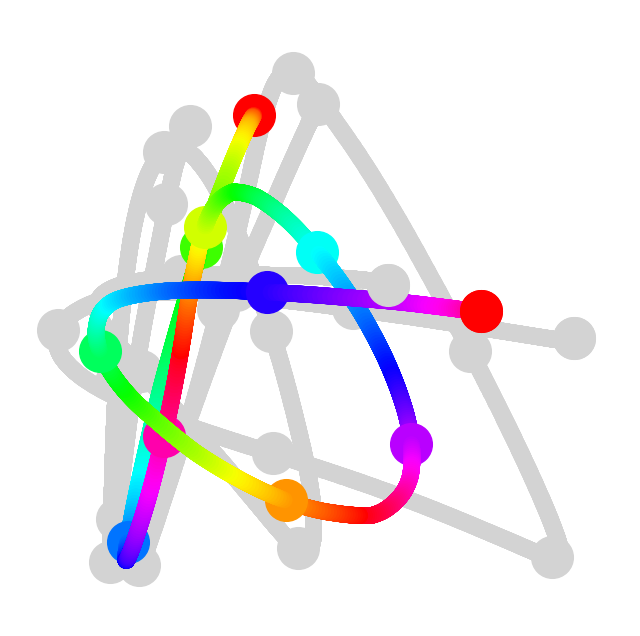

In [54]:

f = plt.figure(figsize=(8,8))
for i in range(1,101):
    render_frame(i)
    plt.savefig(f"simpleInterpGif/simpleInterpolation-{i}.jpg",bbox_inches='tight')    

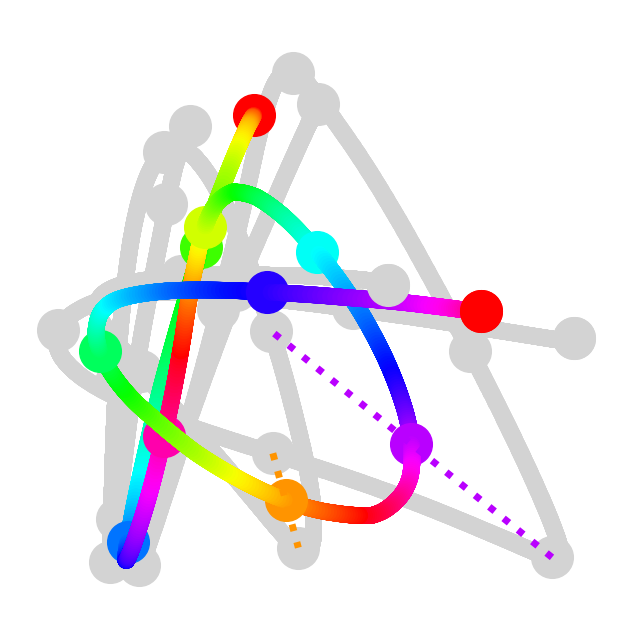

In [56]:
f = plt.figure(figsize=(8,8))
render_frame(100,True)
plt.savefig(f"simpleInterpolationStaticExample.jpg",bbox_inches='tight')    